<a href="https://colab.research.google.com/github/NainaAgrawal/ecommerce_sales_analysis/blob/main/ecommerceanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

['Brazilian E-Commerce Public Dataset by Olist'](https://www.kaggle.com/olistbr/brazilian-ecommerce)
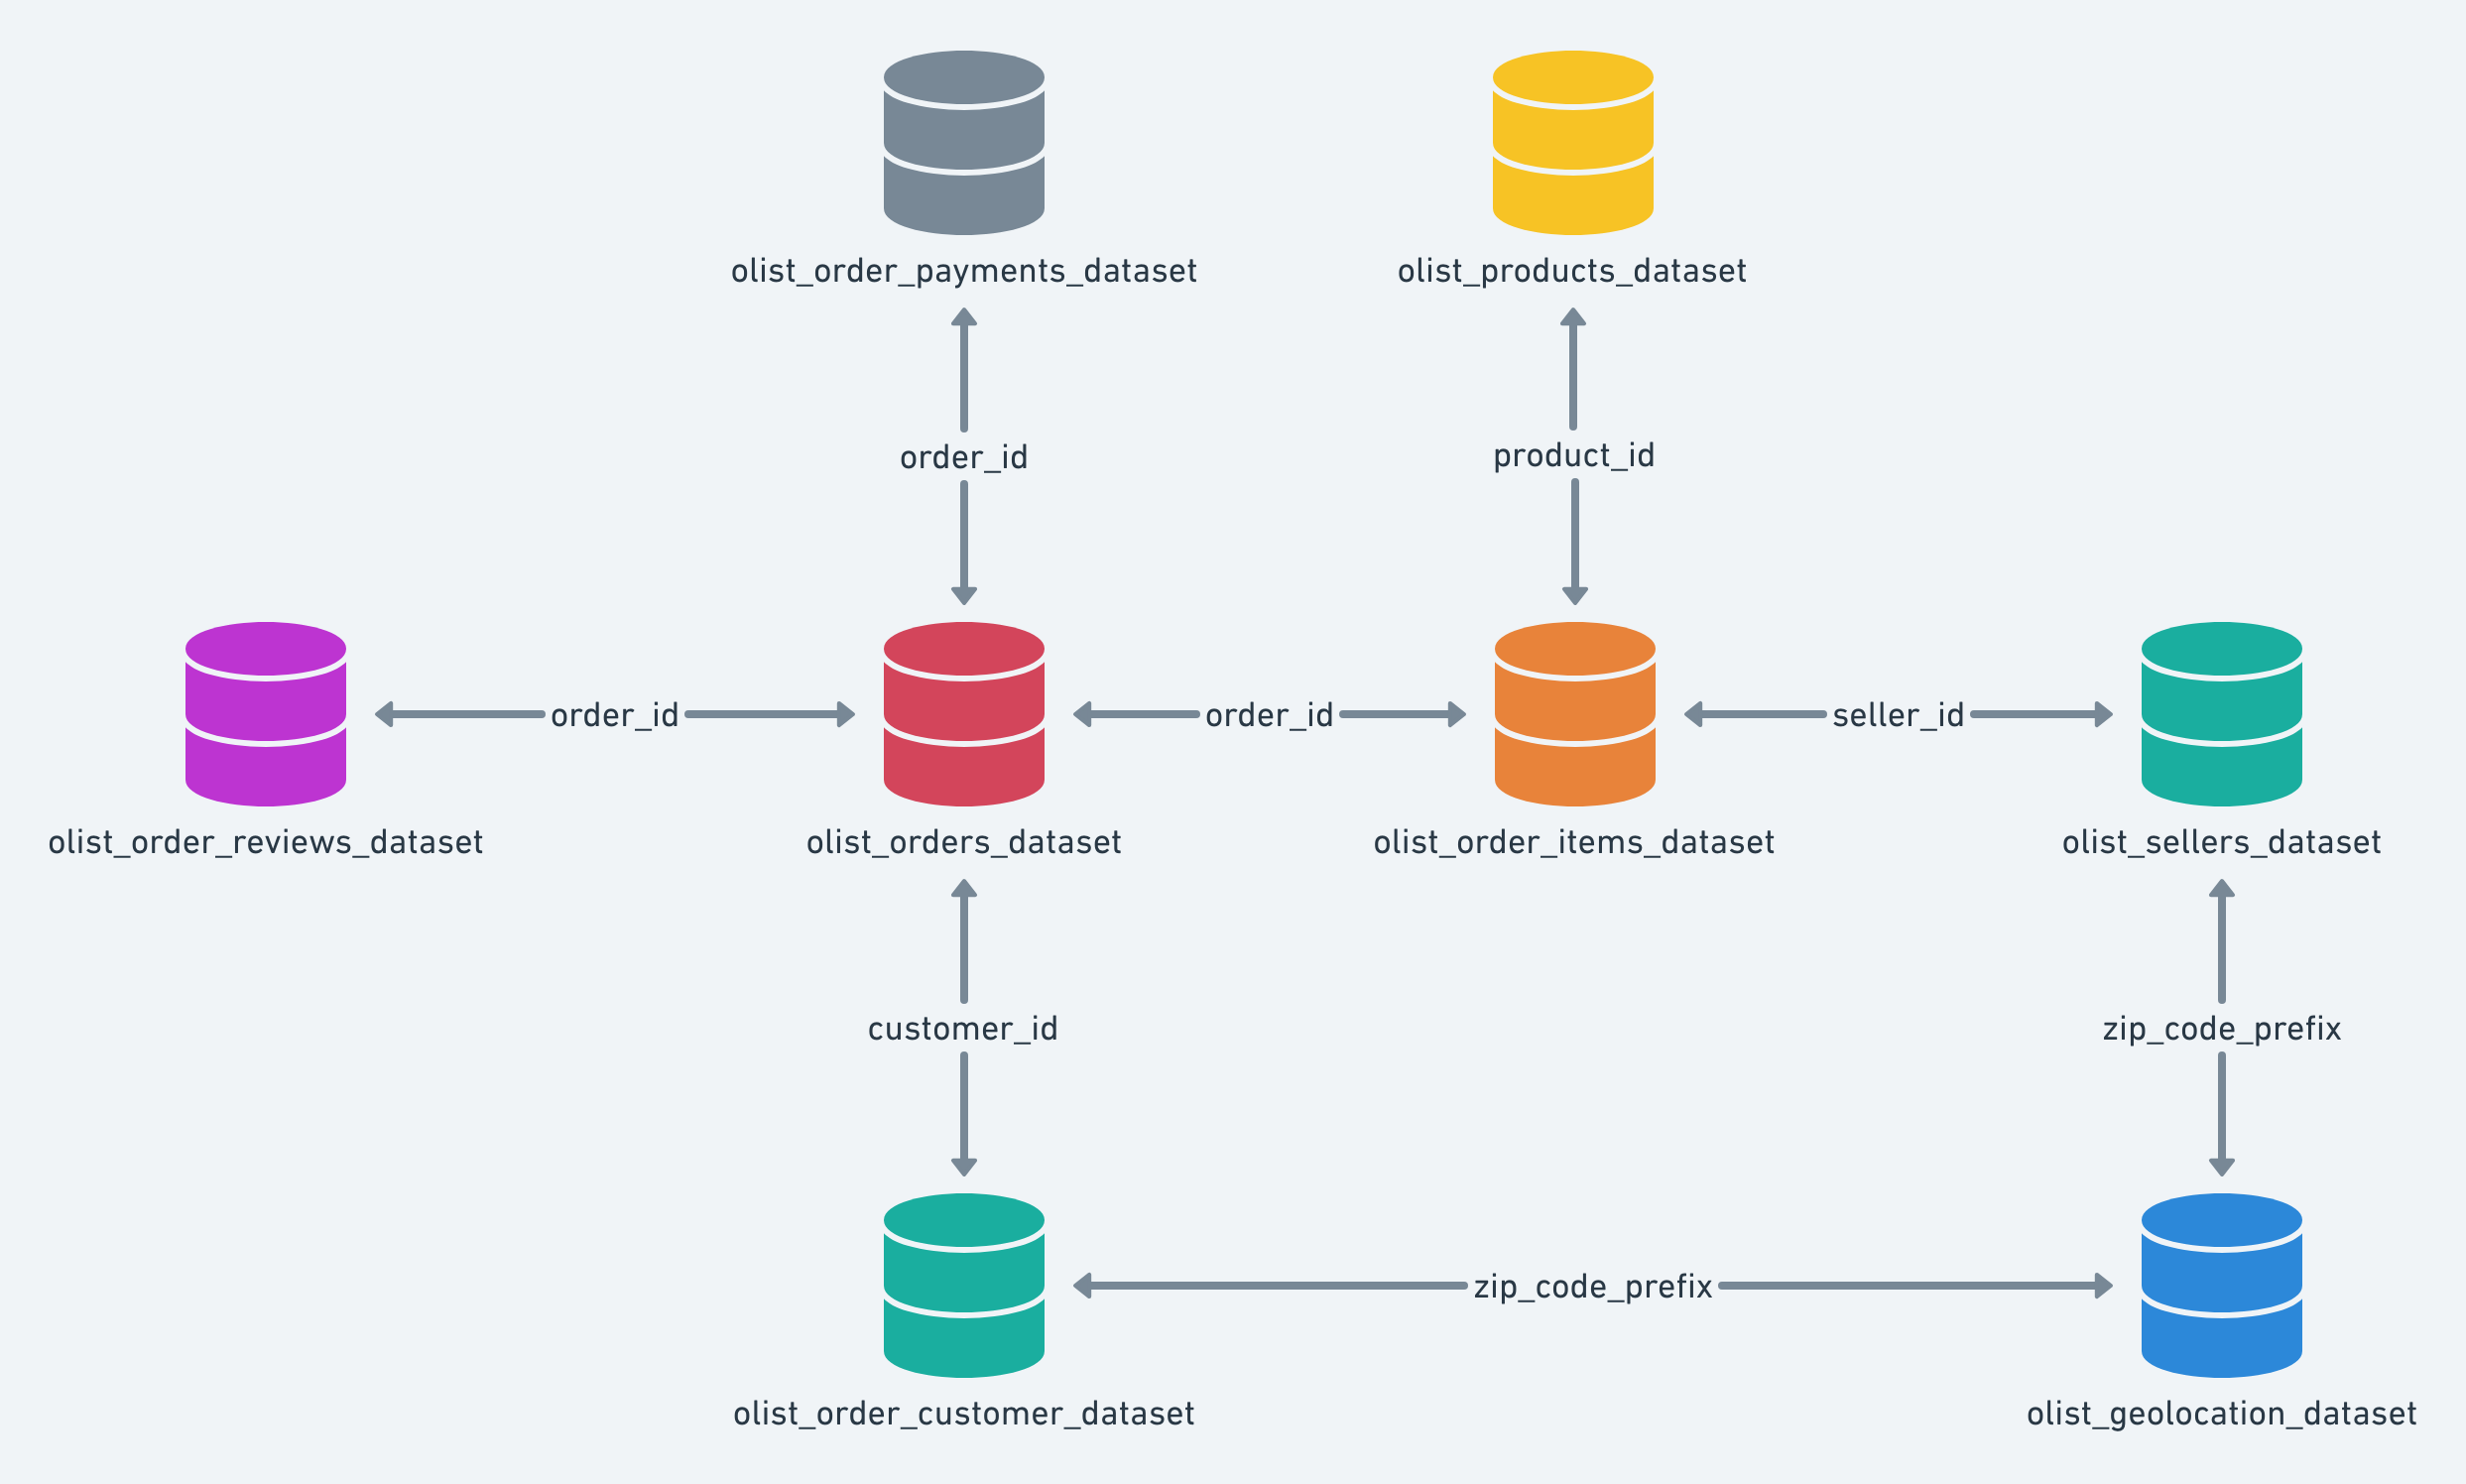

Importing Packages and Data: **START**

In [14]:
%%time
!wget https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

--2021-06-22 19:41:10--  https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz’

spark-3.1.2-bin-had 100%[===================>] 218.23M   583KB/s    in 7m 29s  

2021-06-22 19:48:40 (497 KB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz’ saved [228834641/228834641]



In [15]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

In [4]:
%%time
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q  https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
# !tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark   

CPU times: user 48.3 ms, sys: 32.3 ms, total: 80.6 ms
Wall time: 7.07 s


In [16]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [17]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

from pyspark.sql import HiveContext
hc = HiveContext(sc)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tqdm
pd.set_option('display.max_colwidth', None)

# from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
# from pyspark.ml.regression import RandomForestRegressor, LinearRegression
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
# from pyspark.ml import Pipeline, Model
from pyspark.sql.functions import col

# for google colab
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/', force_remount=True )

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Brazilian_ECommerce_Dataset")
!ls

Mounted at /content/drive/
'Brazilian E-Commerce Public Dataset'   ecommerceanalysis.ipynb




1.   Product analysis; Which product is sold most
2.   Seller analysis
3.   seller rating Feature engineering
4.   seller data
5.   order data analysis



In [19]:
ls 'Brazilian E-Commerce Public Dataset'

olist_customers_dataset.csv       olist_orders_dataset.csv
olist_geolocation_dataset.csv     olist_products_dataset.csv
olist_order_items_dataset.csv     olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [20]:
cus = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_customers_dataset.csv', dtype = str) # loading csv file with every field as string dtype
hc.createDataFrame(cus.astype(str)).registerTempTable('cus')   # converting python dataframe to pyspark dataframe, then creating hive table for the dataframe
geo = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_geolocation_dataset.csv', dtype = str)
hc.createDataFrame(geo.astype(str)).registerTempTable('geo')
ord = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_orders_dataset.csv', dtype = str)
hc.createDataFrame(ord.astype(str)).registerTempTable('ord')
ordit = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_order_items_dataset.csv', dtype = str)
hc.createDataFrame(ordit.astype(str)).registerTempTable('ordit')
ordpy = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_order_payments_dataset.csv', dtype = str)
hc.createDataFrame(ordpy.astype(str)).registerTempTable('ordpy')
ordrv = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_order_reviews_dataset.csv', dtype = str)
hc.createDataFrame(ordrv.astype(str)).registerTempTable('ordrv')
prod = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_products_dataset.csv', dtype = str)
hc.createDataFrame(prod.astype(str)).registerTempTable('prod')
prodcat = pd.read_csv('Brazilian E-Commerce Public Dataset/product_category_name_translation.csv', dtype = str)
hc.createDataFrame(prodcat.astype(str)).registerTempTable('prodcat')
sell = pd.read_csv('Brazilian E-Commerce Public Dataset/olist_sellers_dataset.csv', dtype = str)
hc.createDataFrame(sell.astype(str)).registerTempTable('sell')

In [21]:
hc.sql("SHOW TABLES").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |      cus|       true|
|        |      geo|       true|
|        |      ord|       true|
|        |    ordit|       true|
|        |    ordpy|       true|
|        |    ordrv|       true|
|        |     prod|       true|
|        |  prodcat|       true|
|        |     sell|       true|
+--------+---------+-----------+



In [22]:
cus.columns, geo.columns, ord.columns, ordit.columns, ordpy.columns, ordrv.columns, prod.columns, prodcat.columns, sell.columns

(Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
        'customer_city', 'customer_state'],
       dtype='object'),
 Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
        'geolocation_city', 'geolocation_state'],
       dtype='object'),
 Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
        'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date'],
       dtype='object'),
 Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
        'shipping_limit_date', 'price', 'freight_value'],
       dtype='object'),
 Index(['order_id', 'payment_sequential', 'payment_type',
        'payment_installments', 'payment_value'],
       dtype='object'),
 Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
        'review_comment_message', 'review_creation_date',
        'review_answer_timestamp'],
       dtype='object'),


Importing Packages and Data: **STOP**

# Merge tables order, order_item, products 
inorder to conclude which product is sold the most.


### Table name, Count of records, Number of Columns, Count of Unique id of each Column/Table.

In [23]:
l1, l2, l3, l4 = [], [], [], []
for i in tqdm.tqdm(hc.sql('''show tables''').toPandas()['tableName'].to_list()):
  l1.append(i)
  l2.append(hc.sql(f'''select count(*) as counts from {i}''').toPandas()['counts'].to_list()[0])
  l3.append(hc.sql(f'''select * from {i} limit 0''').toPandas().shape[1])
  l5 = []
  for j in ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'geolocation_zip_code_prefix', 'order_id', 'order_item_id', 
            'product_id', 'seller_id', 'review_id', 'product_category_name', 'product_category_name_english', 'seller_zip_code_prefix']:
    try:
      l5.append({j : hc.sql(f'''select count(distinct {j}) as counts from {i}''').toPandas()['counts'].to_list()[0]})
    except:
      pass
  l4.append(l5)

100%|██████████| 9/9 [00:47<00:00,  5.33s/it]


In [24]:
pd.DataFrame({'name' : l1, 'records' : l2, 'columns' : l3, 'distinctColCounts' : l4} )

name  ...                                                                             distinctColCounts
0      cus  ...  [{'customer_id': 99441}, {'customer_unique_id': 96096}, {'customer_zip_code_prefix': 14994}]
1      geo  ...                                                      [{'geolocation_zip_code_prefix': 19015}]
2      ord  ...                                                 [{'customer_id': 99441}, {'order_id': 99441}]
3    ordit  ...      [{'order_id': 98666}, {'order_item_id': 21}, {'product_id': 32951}, {'seller_id': 3095}]
4    ordpy  ...                                                                         [{'order_id': 99440}]
5    ordrv  ...                                                   [{'order_id': 99441}, {'review_id': 99173}]
6     prod  ...                                        [{'product_id': 32951}, {'product_category_name': 74}]
7  prodcat  ...                        [{'product_category_name': 71}, {'product_category_name_english': 71}]
8     sell  ...                                       [{'seller_id': 3095}, {'seller_zip_code_prefix': 2246}]

[9 rows x 4 columns]

**Merge all tables**


In [25]:
hc.sql('''select * from ordrv limit 2''').toPandas()

review_id  ... review_answer_timestamp
0  7bc2406110b926393aa56f80a40eba40  ...     2018-01-18 21:46:59
1  80e641a11e56f04c1ad469d5645fdfde  ...     2018-03-11 03:05:13

[2 rows x 7 columns]

In [26]:
', '.join(hc.sql('''select * from geo limit 0''').columns)

'geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state'

In [27]:
hc.sql('''select count(distinct seller_zip_code_prefix) from sell limit 1''').toPandas()

count(DISTINCT seller_zip_code_prefix)
0                                    2246

In [28]:
hc.sql('''select count(distinct geolocation_zip_code_prefix) from geo limit 1''').toPandas()

count(DISTINCT geolocation_zip_code_prefix)
0                                        19015

create ordit 

In [29]:
%%time
hc.sql('''drop table if exists ordit1''')
hc.sql('''create table ordit1 as
select order_id, count(distinct order_item_id) as order_item_counts, product_id, seller_id, shipping_limit_date, sum(price) as price, sum(freight_value) as freight_value
 from ordit group by order_id, product_id, seller_id, shipping_limit_date ''')

hc.sql('''select count(*) from ordit1 ''').toPandas()

CPU times: user 170 ms, sys: 29.2 ms, total: 199 ms
Wall time: 25.7 s


In [30]:
hc.sql('''select * from ordit1 limit 2''').toPandas()

order_id  order_item_counts  ...  price freight_value
0  0ab0e6cc12734a3c6311f9a0db8b2555                  1  ...   15.0         15.79
1  1bc1acc1a9efde3aaa00688fc9d33d2a                  2  ...  239.8         33.20

[2 rows x 7 columns]

ordpy

In [31]:
%%time
hc.sql('''drop table if exists ordpy1''')
hc.sql('''create table ordpy1 as
select order_id, count(distinct payment_sequential) as payment_sequential_counts,

sum(payment_type_boleto) as payment_type_boleto, sum(payment_type_not_defined) as payment_type_not_defined, 
sum(payment_type_credit_card) as payment_type_credit_card, sum(payment_type_voucher) as payment_type_voucher, sum(payment_type_debit_card) as payment_type_debit_card,

count(distinct payment_installments) as payment_installments_counts,

sum(payment_value_boleto) as payment_value_boleto, sum(payment_value_not_defined) as payment_value_not_defined, sum(payment_value_credit_card) as payment_value_credit_card,
sum(payment_value_voucher) as payment_value_voucher, sum(payment_value_debit_card) as payment_value_debit_card,
sum(payment_value) as payment_value_total

 from (
select order_id, payment_sequential, 
case when payment_type = 'boleto' then 1 else 0 end as payment_type_boleto,
case when payment_type = 'not_defined' then 1 else 0 end as payment_type_not_defined,
case when payment_type = 'credit_card' then 1 else 0 end as payment_type_credit_card,
case when payment_type = 'voucher' then 1 else 0 end as payment_type_voucher,
case when payment_type = 'debit_card' then 1 else 0 end as payment_type_debit_card,

payment_installments, 

case when payment_type = 'boleto' then payment_value else 0 end as payment_value_boleto,
case when payment_type = 'not_defined' then payment_value else 0 end as payment_value_not_defined,
case when payment_type = 'credit_card' then payment_value else 0 end as payment_value_credit_card,
case when payment_type = 'voucher' then payment_value else 0 end as payment_value_voucher,
case when payment_type = 'debit_card' then payment_value else 0 end as payment_value_debit_card,

payment_value from
ordpy
)
group by order_id ''')

hc.sql('''select count(*) from ordpy1 ''').toPandas()

CPU times: user 169 ms, sys: 21.4 ms, total: 191 ms
Wall time: 22.5 s


In [32]:
hc.sql('''select * from ordpy1 limit 2''').toPandas()

order_id  ...  payment_value_total
0  c195f1fa107c4161ca71b557b72b01db  ...                71.62
1  d6abdb38c0ac915fac541669992e01fe  ...                61.63

[2 rows x 14 columns]

ordrv

In [33]:
%%time
hc.sql('''drop table if exists ordrv1''')
hc.sql('''create table ordrv1 as
select review_id, order_id, review_score from (
select *, row_number() over (partition by order_id order by review_answer_timestamp desc) pos_time
from ordrv
) where pos_time = 1
''')

hc.sql('''select count(*) from ordrv1 ''').toPandas()

CPU times: user 99.5 ms, sys: 18 ms, total: 117 ms
Wall time: 13.6 s


In [34]:
%%time
hc.sql('''drop table if exists geo1''')
hc.sql('''create table geo1 as
select geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state from (
select *, row_number() over (partition by geolocation_zip_code_prefix order by geolocation_lat, geolocation_lng desc) pos_geo
from geo
) where pos_geo = 1
''')

hc.sql('''select count(*) from geo1 ''').toPandas()

CPU times: user 127 ms, sys: 13.3 ms, total: 140 ms
Wall time: 18.9 s


In [35]:
hc.sql('''select * from ordrv1 limit 2''').toPandas()

review_id  ... review_score
0  ca13795db8e305829cb406ef608d87f9  ...            1
1  73bedd3ee6355c16e28ac83690f8720a  ...            4

[2 rows x 3 columns]

combining tables

In [36]:
%%time
hc.sql('''drop table if exists ecommerce1''')
hc.sql('''create table ecommerce1 as
select 
coalesce(ord.order_id, ordpy1.order_id, ordrv1.order_id) as order_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
payment_sequential_counts, payment_type_boleto, payment_type_not_defined, payment_type_credit_card, payment_type_voucher, payment_type_debit_card, payment_installments_counts, payment_value_boleto, payment_value_not_defined, payment_value_credit_card, payment_value_voucher, payment_value_debit_card, payment_value_total,
review_id, review_score,
cus.customer_id, customer_zip_code_prefix, customer_city, customer_state, geolocation_lat as customer_lat, geolocation_lng as customer_lng

from ord

right join ordpy1
on ord.order_id = ordpy1.order_id

right join ordrv1
on ord.order_id = ordrv1.order_id

right join cus
on ord.customer_id = cus.customer_id

left join geo1
on geo1.geolocation_zip_code_prefix = cus.customer_zip_code_prefix

''')

hc.sql('''select count(*) from ecommerce1 ''').toPandas()

CPU times: user 129 ms, sys: 19.4 ms, total: 149 ms
Wall time: 20.3 s


In [37]:
hc.sql('''select count(*) from ecommerce1 ''').toPandas()

count(1)
0     99441

In [38]:
%%time
hc.sql('''drop table if exists ecommerce2''')
hc.sql('''create table ecommerce2 as
select 
prod.product_id, prod.product_category_name, 
product_category_name_english,
order_id, order_item_counts, shipping_limit_date, price, freight_value,
sell.seller_id, seller_zip_code_prefix, seller_city, seller_state, geolocation_lat as seller_lat, geolocation_lng as seller_lng

from prod

left join prodcat
on prod.product_category_name = prodcat.product_category_name

left join ordit1
on prod.product_id = ordit1.product_id

left join sell
on ordit1.seller_id = sell.seller_id

left join geo1
on geo1.geolocation_zip_code_prefix = sell.seller_zip_code_prefix

''')

hc.sql('''select count(*) from ecommerce2 ''').toPandas()

CPU times: user 218 ms, sys: 42.4 ms, total: 260 ms
Wall time: 30.3 s


In [39]:
%%time
hc.sql('''drop table if exists ecommerce''')
hc.sql('''create table ecommerce as

select 
coalesce(ecommerce1.order_id, ecommerce2.order_id) as order_id,

product_id, product_category_name, 
product_category_name_english,
order_item_counts, shipping_limit_date, price, freight_value,
seller_id, seller_zip_code_prefix, seller_city, seller_state, seller_lat, seller_lng,

order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
payment_sequential_counts, payment_type_boleto, payment_type_not_defined, payment_type_credit_card, payment_type_voucher, payment_type_debit_card, payment_installments_counts, payment_value_boleto, payment_value_not_defined, payment_value_credit_card, payment_value_voucher, payment_value_debit_card, payment_value_total,
review_id, review_score,
customer_id, customer_zip_code_prefix, customer_city, customer_state, customer_lat, customer_lng

from ecommerce1

right join ecommerce2
on ecommerce1.order_id = ecommerce2.order_id

''')

hc.sql('''select count(*) from ecommerce ''').toPandas()

CPU times: user 138 ms, sys: 15.9 ms, total: 154 ms
Wall time: 27.9 s


In [40]:
hc.sql('''select * from ecommerce limit 2''').toPandas()

order_id  ...        customer_lng
0  00024acbcdf0a6daa1e931b038114c75  ...  -46.67479547760594
1  00789ce015e7e5791c7914f32bb4fad4  ...   -43.5238334248658

[2 rows x 41 columns]

In [41]:
ecom = hc.sql('''SELECT * FROM ecommerce''').toPandas()
ecom.shape

(102425, 41)

In [42]:
ecom.isnull().sum().sum()/len(ecom) * 100

2.465218452526239

In [43]:
# pd.concat([ecom.isnull().sum(), ecom.apply(pd.Series.nunique)], axis = 1)
pd.DataFrame({'missing' : ecom.isnull().sum(), 'missing_%' : ecom.isnull().sum()/len(ecom) * 100, 'unique' : ecom.apply(pd.Series.nunique)})

missing  missing_%  unique
order_id                             0   0.000000   98666
product_id                           0   0.000000   32951
product_category_name                0   0.000000      74
product_category_name_english     1482   1.446912      71
order_item_counts                    0   0.000000      16
shipping_limit_date                  0   0.000000   93318
price                                0   0.000000    6981
freight_value                        0   0.000000    7971
seller_id                            0   0.000000    3095
seller_zip_code_prefix               0   0.000000    2246
seller_city                          0   0.000000     611
seller_state                         0   0.000000      23
seller_lat                         225   0.219673    2237
seller_lng                         225   0.219673    2237
order_status                         1   0.000976       7
order_purchase_timestamp             1   0.000976   98111
order_approved_at                    1   0.000976   90174
order_delivered_carrier_date         1   0.000976   81017
order_delivered_customer_date        1   0.000976   95664
order_estimated_delivery_date        1   0.000976     449
payment_sequential_counts            1   0.000976      20
payment_type_boleto                  1   0.000976       2
payment_type_not_defined             1   0.000976       1
payment_type_credit_card             1   0.000976       3
payment_type_voucher                 1   0.000976      20
payment_type_debit_card              1   0.000976       3
payment_installments_counts          1   0.000976       3
payment_value_boleto                 1   0.000976   10473
payment_value_not_defined            1   0.000976       1
payment_value_credit_card            1   0.000976   25322
payment_value_voucher                1   0.000976    2770
payment_value_debit_card             1   0.000976    1379
payment_value_total                  1   0.000976   27873
review_id                            1   0.000976   98135
review_score                         1   0.000976       5
customer_id                          1   0.000976   98665
customer_zip_code_prefix             1   0.000976   14976
customer_city                        1   0.000976    4110
customer_state                       1   0.000976      27
customer_lat                       284   0.277276   14791
customer_lng                       284   0.277276   14792

In [44]:
ecom = ecom[ecom.review_id.isnull() == False]
ecom.shape

(102424, 41)

In [45]:
ecom = ecom[ecom.product_category_name_english.isnull() == False]
ecom.shape

(100942, 41)

Delivery Time Estimation: ***START***

In [46]:
d1 = ecom[['order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'review_score',
           'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']].drop_duplicates().reset_index(drop = True) 
print(d1.shape)
d1[:2]
# reset_index is used to reorder the index incase we drop some cells. 'Drop = True' is used to delete the extra index column that is created beccause of reset index.

(98406, 8)


order_id  ...          seller_lng
0  00024acbcdf0a6daa1e931b038114c75  ...    -47.366053101687
1  00789ce015e7e5791c7914f32bb4fad4  ...  -46.47108040888402

[2 rows x 8 columns]

In [47]:
d1['difference_of_date'] = (pd.to_datetime(d1['order_estimated_delivery_date']) - pd.to_datetime(d1['order_delivered_customer_date'])).dt.days
d1['late_early_del_date'] = np.where(pd.to_datetime(d1['order_estimated_delivery_date']) >= pd.to_datetime(d1['order_delivered_customer_date']), 1, 0)

In [48]:
d1 = d1.dropna(subset = ['difference_of_date']).reset_index(drop = True) #subset refers to dropping a particular column of a dataframe
d1.shape

(96274, 10)

In [49]:
d1[:2]

order_id  ... late_early_del_date
0  00024acbcdf0a6daa1e931b038114c75  ...                   1
1  00789ce015e7e5791c7914f32bb4fad4  ...                   1

[2 rows x 10 columns]

Percentage of early and late deliveries:




In [50]:
d1.late_early_del_date.value_counts() / len(d1) * 100

1    91.984336
0     8.015664
Name: late_early_del_date, dtype: float64

In [51]:
d2 = d1[d1.late_early_del_date == 0].reset_index(drop = True)
d2[:2]

order_id  ... late_early_del_date
0  037578a0b32fa190a1fe9f1de5fd3f30  ...                   0
1  069514f19868af8a75ebe98f43d33900  ...                   0

[2 rows x 10 columns]

In [52]:
d2.difference_of_date.min(), d2.difference_of_date.max()

(-189.0, -1.0)

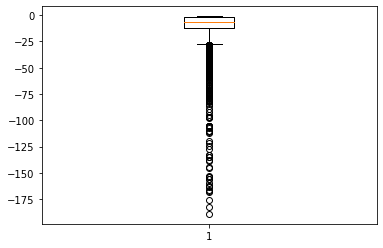

In [53]:
plt.boxplot(d2.difference_of_date)
plt.show()

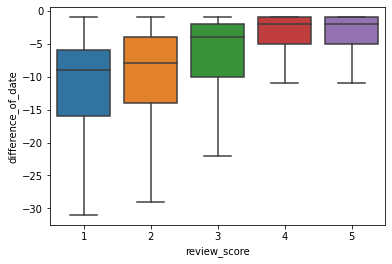

In [54]:
seaborn.boxplot(x= d2['review_score'].astype(int), y='difference_of_date', data=d2, showfliers = False)
plt.show()

Analysis of Boxplot:

1. Assumption: Late delivery is indirectly proportional to review score.
2. Observation: Matches Assumption perfectly
3. Cause of late delivery: 

  3.1 Assumption: Distance

  3.2 Observation:
4. Strategy: 

  4.1 Difference between the zip code of the customer and seller

  4.2 Difference between the order approved date and order carrier date: **pending** 

  suggestion to seller:

  4.3 Increase estimation date
  
  4.4 Change carrier


In [85]:
d2.shape

(7717, 11)

In [56]:
from geopy.distance import geodesic

distance formula applied on d2



In [57]:
distance2 = []
for i in tqdm.tqdm(d2.order_id.to_list()):
  try:
    origin = (d2[d2.order_id == i].seller_lat.to_list()[0], d2[d2.order_id == i].seller_lng.to_list()[0])  # (latitude, longitude) don't confuse
    dest = (d2[d2.order_id == i].customer_lat.to_list()[0], d2[d2.order_id == i].customer_lng.to_list()[0])

    distance2.append(geodesic(origin, dest).kilometers)
  except:
    distance2.append(np.nan)

100%|██████████| 7717/7717 [00:46<00:00, 165.97it/s]


Distance formula applied on d1

In [58]:
# distance = []
# for i in tqdm.tqdm(d1.order_id.to_list()):
#   try:
#     origin = (d1[d1.order_id == i].seller_lat.to_list()[0], d1[d1.order_id == i].seller_lng.to_list()[0])  # (latitude, longitude) don't confuse
#     dest = (d1[d1.order_id == i].customer_lat.to_list()[0], d1[d1.order_id == i].customer_lng.to_list()[0])

#     distance.append(geodesic(origin, dest).kilometers)
#   except:
#     distance.append(np.nan)

100%|██████████| 96274/96274 [1:08:45<00:00, 23.33it/s]


In [82]:
# d1['distance'] = distance

In [ ]:
# d1.to_excel('/content/drive/My Drive/Colab Notebooks/Brazilian_ECommerce_Dataset/d1_customer_distance_km.xlsx', header = True, index = False)

In [100]:
d1 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Brazilian_ECommerce_Dataset/d1_customer_distance_km.xlsx', dtype = str)
print(d1.shape)

(96274, 11)


In [83]:
d1[:2]

order_id  ...    distance
0  00024acbcdf0a6daa1e931b038114c75  ...  287.452102
1  00789ce015e7e5791c7914f32bb4fad4  ...  309.054810

[2 rows x 11 columns]

In [60]:
d2['distance'] = distance2

In [88]:
d2[:2]

order_id  ...     distance
0  037578a0b32fa190a1fe9f1de5fd3f30  ...  1465.989586
1  069514f19868af8a75ebe98f43d33900  ...  1208.599630

[2 rows x 11 columns]

## d2 boxplot

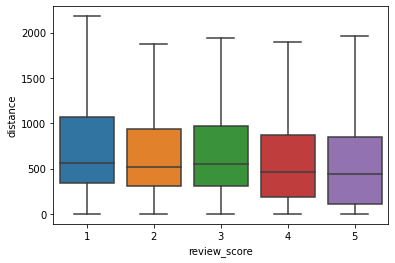

In [62]:
seaborn.boxplot(x= d2['review_score'].astype(int), y='distance', data=d2, showfliers = False)
plt.show()

## d1 boxplot

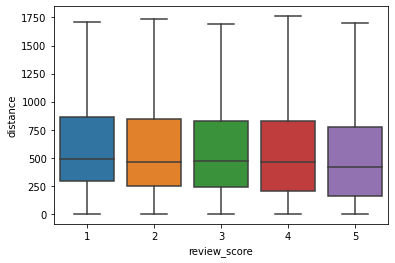

In [101]:
seaborn.boxplot(x= d1['review_score'].astype(int), y='distance', data=d1, showfliers = False)
plt.show()

In [89]:
import plotly.graph_objects as go

In [102]:
fig = go.Figure(data=go.Scattergeo(
        lon = d1['customer_lng'],
        lat = d1['customer_lat'],
        # text = df['text'],
        mode = 'markers',
        marker_color = 'pink'
        ))

fig.update_layout(
        title = 'Most trafficked US airports<br>(Hover for airport names)',
  geo_scope='south america',  
    )
fig.show()

Delivery Time Estimation: ***STOP***

Product_Analysis: **START**

In [64]:
ecom[:2]

order_id  ...        customer_lng
0  00024acbcdf0a6daa1e931b038114c75  ...  -46.67479547760594
1  00789ce015e7e5791c7914f32bb4fad4  ...   -43.5238334248658

[2 rows x 41 columns]

In [65]:
ecom.sort_values(['price'], ascending = [False])[:5]

order_id  ...         customer_lng
10135  03caa2c082116e1d31e67e9ae3700499  ...  -43.182621403139215
13556  736e1922ae60d0d6a89247b851902527  ...   -40.34986362495689
96832  0812eb902a67711a1cb742b3cdaa65ae  ...   -54.56207806910385
48487  fefacc66af859508bf1a7934eab1e97f  ...   -40.28662787748842
35185  f5136e38d1a14a4dbd87dff67da82701  ...   -49.96157575448745

[5 rows x 41 columns]

In [66]:
pp = ecom[['product_category_name_english','price']].sort_values(['price'], ascending = [False])[:5]

top 5 products sold by order_id, and rest of all the products should be others.
Graph: Piechart, Barplot

In [67]:
pd.value_counts(ord.order_status)

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [68]:
pd.value_counts(ecom.order_id)[:5]

ca3625898fbd48669d50701aba51cd5f    8
ad850e69fce9a512ada84086651a2e7d    7
7d8f5bfd5aff648220374a2df62e84d5    7
77df84f9195be22a4e9cb72ca9e8b4c2    7
aa0b425987bdeae4a29c616a2bc3a08a    6
Name: order_id, dtype: int64

1st method to use "in" :

In [69]:
most_sold_products = ecom[ecom['order_status'].isin(['delivered','shipped', 'invoiced'])]. \
groupby('product_category_name_english')['order_id'].count().sort_values(ascending = False).reset_index()

2nd method to use "in" :

In [70]:
ecom.query("order_status in ('delivered','shipped', 'invoiced') "). \
groupby('product_category_name_english')['order_id'].count().sort_values(ascending = False).reset_index()[:5]

product_category_name_english  order_id
0                bed_bath_table     10135
1                 health_beauty      8971
2                sports_leisure      7790
3         computers_accessories      6834
4               furniture_decor      6728

In [71]:
most_sold_products[:5]

product_category_name_english  order_id
0                bed_bath_table     10135
1                 health_beauty      8971
2                sports_leisure      7790
3         computers_accessories      6834
4               furniture_decor      6728

  ### Most products sold by product category:

In [72]:
v1 = pd.concat([most_sold_products[:5], 
           pd.DataFrame({'product_category_name_english' : 'others', 'order_id' : sum(most_sold_products.order_id[5:])}, index = [5])
           ])
v1

product_category_name_english  order_id
0                bed_bath_table     10135
1                 health_beauty      8971
2                sports_leisure      7790
3         computers_accessories      6834
4               furniture_decor      6728
5                        others     59733

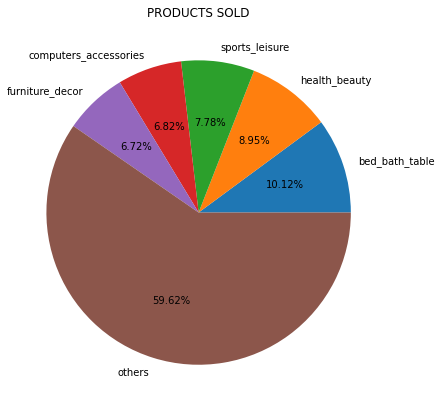

In [73]:
plt.figure(figsize = [7,7])
plt.pie(v1.order_id, labels = v1.product_category_name_english, autopct='%1.2f%%')
plt.title("PRODUCTS SOLD")
plt.show()

In [74]:
ecom[:2]

order_id  ...        customer_lng
0  00024acbcdf0a6daa1e931b038114c75  ...  -46.67479547760594
1  00789ce015e7e5791c7914f32bb4fad4  ...   -43.5238334248658

[2 rows x 41 columns]

In [75]:
most_sold_products_by_year = ecom[ecom['order_status'].isin(['delivered','shipped', 'invoiced'])]. \
groupby([pd.to_datetime(ecom.order_delivered_customer_date).dt.year, 
         'product_category_name_english'])['order_id'].count().sort_values(ascending = False).reset_index()
most_sold_products_by_year.shape

(170, 3)

In [76]:
most_sold_products_by_year.loc[~most_sold_products_by_year.product_category_name_english.isin(v1.product_category_name_english), 'product_category_name_english'] = 'others'

In [77]:
most_sold_products_by_year = most_sold_products_by_year.groupby(['order_delivered_customer_date',	'product_category_name_english'])['order_id'].sum().sort_values(ascending = False).reset_index()
most_sold_products_by_year.shape

(18, 3)

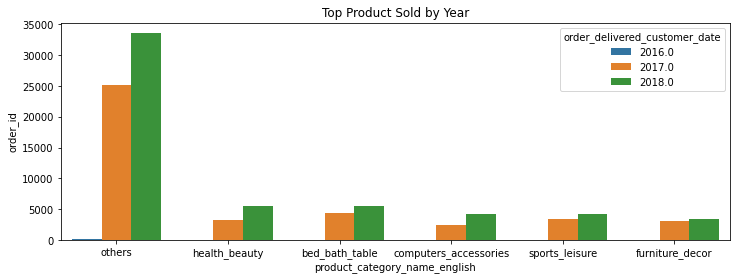

In [78]:
plt.figure(figsize = [12, 4])
seaborn.barplot(x = 'product_category_name_english', y = 'order_id', hue = 'order_delivered_customer_date', data = most_sold_products_by_year)
plt.title("Top Product Sold by Year")
plt.show()

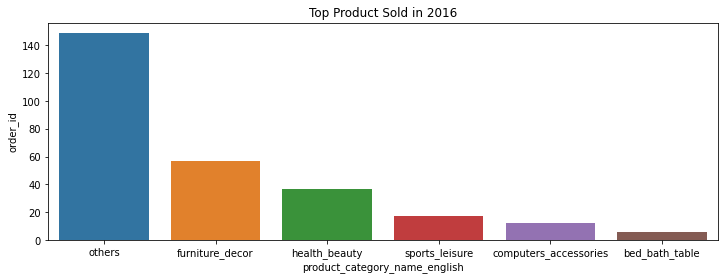

In [79]:
plt.figure(figsize = [12, 4])
seaborn.barplot(x = 'product_category_name_english', y = 'order_id', data = most_sold_products_by_year[most_sold_products_by_year.order_delivered_customer_date == 2016.0])
plt.title("Top Product Sold in 2016")
plt.show()

Product_Analysis: **STOP**